In [8]:
# --- imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from pygam import LinearGAM, s, te, f

# =========================
# 1) Config básica
# =========================
SENSORS = ['28079035', '28079050', '28079056']
SPLIT_DATE = '2024-01-01'
YLABEL = 'Efecto parcial en NO₂ (µg m⁻³)'

# --- añadir cerca de la cabecera del script ---
# Tamaños de fuente más grandes
TITLE_SIZE = 16
AXIS_LABEL_SIZE = 14
TICK_SIZE = 12
LEGEND_SIZE = 12
SUPTITLE_SIZE = 18

import matplotlib.pyplot as plt
plt.rcParams.update({
    'axes.titlesize': TITLE_SIZE,
    'axes.labelsize': AXIS_LABEL_SIZE,
    'xtick.labelsize': TICK_SIZE,
    'ytick.labelsize': TICK_SIZE,
    'legend.fontsize': LEGEND_SIZE
})

# Etiqueta del eje Y común
YLABEL = 'Efecto parcial en NO₂ (µg m⁻³)'

# Títulos legibles por panel
PRETTY_TITLES = {
    'intensidad_lag8':  'Intensidad de tráfico (retardo 8 h)',
    't2m_ma6':          'Temperatura del aire (media 6 h)',
    'd2m_ma6':          'Punto de rocío (media 6 h)',
    'sp_anom':          'Anomalía de presión superficial',
    'wind_speed_ma24':  'Velocidad del viento (media 24 h)',
    'wind_dir_sin_ma6': 'Dirección del viento — componente seno (media 6 h)',
    'tp_sum24':         'Precipitación acumulada (24 h)',
    'ssr_sum24_anom':   'Radiación solar neta (anomalía, 24 h)',
    'hour_pair':        'Ciclo diario (hora del día)',
    'dow_pair':         'Ciclo semanal (día de la semana)',
    'season_pair':      'Estacionalidad (estación del año)',
    'weekend':          'Efecto fin de semana'
}


# features en el orden exacto de columnas en X
FEATURES = [
    'intensidad_lag8',   # 0
    't2m_ma6',           # 1
    'd2m_ma6',           # 2
    'sp_anom',           # 3
    'wind_speed_ma24',   # 4
    'wind_dir_sin_ma6',  # 5
    'tp_sum24',          # 6
    'ssr_sum24_anom',    # 7
    'hour_sin',          # 8
    'hour_cos',          # 9
    'day_of_week_sin',   # 10
    'day_of_week_cos',   # 11
    'season_sin',        # 12
    'season_cos',        # 13
    'weekend'            # 14
]

# mapeo de términos del GAM a base cero
TERM_IDX = {
    'intensidad_lag8': 0,
    't2m_ma6':          1,
    'd2m_ma6':          2,
    'sp_anom':          3,
    'wind_speed_ma24':  4,
    'wind_dir_sin_ma6': 5,
    'tp_sum24':         6,
    'ssr_sum24_anom':   7,
    'hour_pair':        8,   # te(8,9)
    'dow_pair':         9,   # te(10,11)
    'season_pair':      10,  # te(12,13)
    'weekend':          11   # f(14)
}

def _safe_sig(sig):
    return sig if sig > 0 else 1e-8

# =========================
# 2) Utils de features
# =========================
def add_time_features(df):
    df = df.copy()
    df['fecha'] = pd.to_datetime(df['fecha'])
    df['hour'] = df['fecha'].dt.hour
    df['day_of_week'] = df['fecha'].dt.dayofweek
    df['month'] = df['fecha'].dt.month
    df['season'] = df['month'].map(lambda m: 0 if m in [12,1,2] else 1 if m in [3,4,5] else 2 if m in [6,7,8] else 3)
    df['weekend'] = df['day_of_week'].isin([5,6]).astype(int)

    df['hour_sin'] = np.sin(2*np.pi*df['hour']/24)
    df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)

    df['day_of_week_sin'] = np.sin(2*np.pi*df['day_of_week']/7)
    df['day_of_week_cos'] = np.cos(2*np.pi*df['day_of_week']/7)

    df['season_sin'] = np.sin(2*np.pi*df['season']/4)
    df['season_cos'] = np.cos(2*np.pi*df['season']/4)
    return df

def make_gam():
    """Arquitectura fija, suave e interpretable."""
    return LinearGAM(
        s(0,  n_splines=9, lam=40) +   # intensidad_lag8
        s(1,  n_splines=9, lam=40) +   # t2m_ma6
        s(2,  n_splines=9, lam=40) +   # d2m_ma6
        s(3,  n_splines=9, lam=60) +   # sp_anom
        s(4,  n_splines=9, lam=60) +   # wind_speed_ma24
        s(5,  n_splines=6, lam=40)  +  # wind_dir_sin_ma6
        s(6,  n_splines=9, lam=60) +   # tp_sum24
        s(7,  n_splines=9, lam=60) +   # ssr_sum24_anom
        te(8,  9,  n_splines=[6,6], lam=[50,50]) +   # hora sin y cos
        te(10, 11, n_splines=[6,6], lam=[50,50]) +   # día de semana sin y cos
        te(12, 13, n_splines=[6,6], lam=[50,50]) +   # estación sin y cos
        f(14)                                        # fin de semana
    )

# =========================
# 3) Entrena por sensor
# =========================
def fit_by_sensor(df, sensor_id):
    idcol = 'id_no2'
    d = df[df[idcol] == sensor_id].copy()
    d = add_time_features(d)

    # split temporal
    train = d[d['fecha'] < SPLIT_DATE].copy()
    test  = d[d['fecha'] >= SPLIT_DATE].copy()

    # anomalías centradas en TRAIN
    train['sp_anom'] = train['sp'] - train['sp'].mean()
    test['sp_anom']  = test['sp']  - train['sp'].mean()

    train['ssr_sum24_anom'] = train['ssr_sum24'] - train['ssr_sum24'].mean()
    test['ssr_sum24_anom']  = test['ssr_sum24']  - train['ssr_sum24'].mean()

    X_train = train[FEATURES].values
    X_test  = test[FEATURES].values
    y_train = train['no2_value'].values
    y_test  = test['no2_value'].values

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    gam = make_gam().fit(X_train_s, y_train)
    rmse = sqrt(mean_squared_error(y_test, gam.predict(X_test_s))) if len(y_test) else np.nan
    return {'gam': gam, 'scaler': scaler, 'train': train, 'test': test, 'rmse': rmse}

# =========================
# 4) Curvas parciales
# =========================
def _pd_curve_single(model, feat_idx, xgrid):
    """Efecto parcial univariante para la feature feat_idx, en unidades originales."""
    gam, scaler = model['gam'], model['scaler']
    term_idx = TERM_IDX[FEATURES[feat_idx]]
    XX = gam.generate_X_grid(term=term_idx, n=len(xgrid))
    mu = scaler.mean_[feat_idx]
    sig = _safe_sig(np.sqrt(scaler.var_[feat_idx]))
    XX[:, feat_idx] = (xgrid - mu) / sig
    return gam.partial_dependence(term=term_idx, X=XX)

def _pd_curve_pair(model, idx_a, idx_b, x_sin, x_cos, term_name):
    """Efecto parcial conjunto 1D para un par seno coseno."""
    gam, scaler = model['gam'], model['scaler']
    term_idx = TERM_IDX[term_name]
    n = len(x_sin)
    p = len(FEATURES)

    mu_a = scaler.mean_[idx_a]
    sig_a = _safe_sig(np.sqrt(scaler.var_[idx_a]))
    mu_b = scaler.mean_[idx_b]
    sig_b = _safe_sig(np.sqrt(scaler.var_[idx_b]))

    # se fija el resto de features en su valor típico estandarizado 0
    XX = np.zeros((n, p))
    XX[:, idx_a] = (x_sin - mu_a) / sig_a
    XX[:, idx_b] = (x_cos - mu_b) / sig_b

    return gam.partial_dependence(term=term_idx, X=XX)

def plot_compare(models):
    colors = {SENSORS[2]:'C0', SENSORS[1]:'C1', SENSORS[0]:'C2'}

    # rangos para univariantes
    mins, maxs = {}, {}
    for f in FEATURES[:8]:
        vals = [m['train'][f].values for m in models.values()]
        v = np.concatenate(vals)
        mins[f], maxs[f] = np.nanpercentile(v, 1), np.nanpercentile(v, 99)

    # mallas para los ciclos
    H = np.linspace(0, 24, 200); H_sin, H_cos = np.sin(2*np.pi*H/24), np.cos(2*np.pi*H/24)
    D = np.linspace(0, 6, 200);  D_sin, D_cos = np.sin(2*np.pi*D/7), np.cos(2*np.pi*D/7)
    S = np.linspace(0, 4, 200);  S_sin, S_cos = np.sin(2*np.pi*S/4), np.cos(2*np.pi*S/4)

    panels = [
        ('intensidad_lag8',), ('t2m_ma6',),
        ('d2m_ma6',), ('sp_anom',),
        ('wind_speed_ma24',), ('wind_dir_sin_ma6',),
        ('tp_sum24',), ('ssr_sum24_anom',),
        ('hour_pair','Hora del día h'), ('dow_pair','Día de la semana'),
        ('season_pair','Estación'), ('weekend',)
    ]

    n = len(panels)
    ncols = 2
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(13, nrows*3.6), constrained_layout=True)
    axes = np.atleast_1d(axes).ravel()

    for ax, p in zip(axes, panels):
        name = p[0]

        if name in ('hour_pair','dow_pair','season_pair'):
            if name == 'hour_pair':
                x, sinv, cosv, xlabel = H, H_sin, H_cos, p[1]; a, b, term_name = 8, 9, 'hour_pair'
            elif name == 'dow_pair':
                x, sinv, cosv, xlabel = D, D_sin, D_cos, p[1]; a, b, term_name = 10, 11, 'dow_pair'
            else:
                x, sinv, cosv, xlabel = S, S_sin, S_cos, p[1]; a, b, term_name = 12, 13, 'season_pair'
                #x = theta / (2*np.pi) * 4
                ax.set_xlabel('Estación'); ax.set_xlim(0, 4)
                ax.set_xticks([0,1,2,3,4]); ax.set_xticklabels(['Invierno','Primavera','Verano','Otoño','Invierno'])

            for sid, m in models.items():
                y = _pd_curve_pair(m, a, b, sinv, cosv, term_name)
                ax.plot(x, y, lw=1.8, label=f'{sid}  RMSE={m["rmse"]:.1f}', color=colors[sid])
            ax.set_xlabel(xlabel, fontsize=AXIS_LABEL_SIZE)

        elif name == 'weekend':
            xs = np.array([0, 1], dtype=float)
            for sid, m in models.items():
                mu = m['scaler'].mean_[14]
                sig = _safe_sig(np.sqrt(m['scaler'].var_[14]))
                term = TERM_IDX['weekend']
                XX = np.zeros((len(xs), len(FEATURES)))
                XX[:, 14] = (xs - mu) / sig
                y = m['gam'].partial_dependence(term=term, X=XX)
                ax.plot(xs, y, marker='o', lw=1.8, label=f'{sid}  RMSE={m["rmse"]:.1f}', color=colors[sid])
            ax.set_xticks([0,1]); ax.set_xticklabels(['Laborable','Fin de semana'])
            ax.set_xlabel('', fontsize=AXIS_LABEL_SIZE)
        else:
            feat = name
            x = np.linspace(mins[feat], maxs[feat], 200)
            for sid, m in models.items():
                j = FEATURES.index(feat)
                y = _pd_curve_single(m, j, x)
                ax.plot(x, y, lw=1.8, label=f'{sid}  RMSE={m["rmse"]:.1f}', color=colors[sid])
            ax.set_xlabel(feat, fontsize=AXIS_LABEL_SIZE)

        ax.axhline(0, ls='--', lw=.8, c='grey')
        ax.grid(alpha=.25)
        ax.set_title(PRETTY_TITLES[name], fontsize=TITLE_SIZE)
        ax.set_ylabel(YLABEL, fontsize=AXIS_LABEL_SIZE)
        ax.tick_params(axis='both', labelsize=TICK_SIZE)
        #ax.legend(frameon=False, fontsize=LEGEND_SIZE, loc='best')

    # apaga ejes sobrantes si n es impar
    for k in range(len(panels), len(axes)):
        axes[k].axis('off')

    fig.suptitle('Efectos parciales del GAM por predictor y estación', y=1.01, fontsize=SUPTITLE_SIZE)
    plt.show()


In [9]:
df = pd.read_parquet("../data/super_processed/7_4_no2_with_traffic_and_1meteo_and_1trafic_id.parquet")

28079035 RMSE test = 15.34
28079050 RMSE test = 14.57
28079056 RMSE test = 19.27


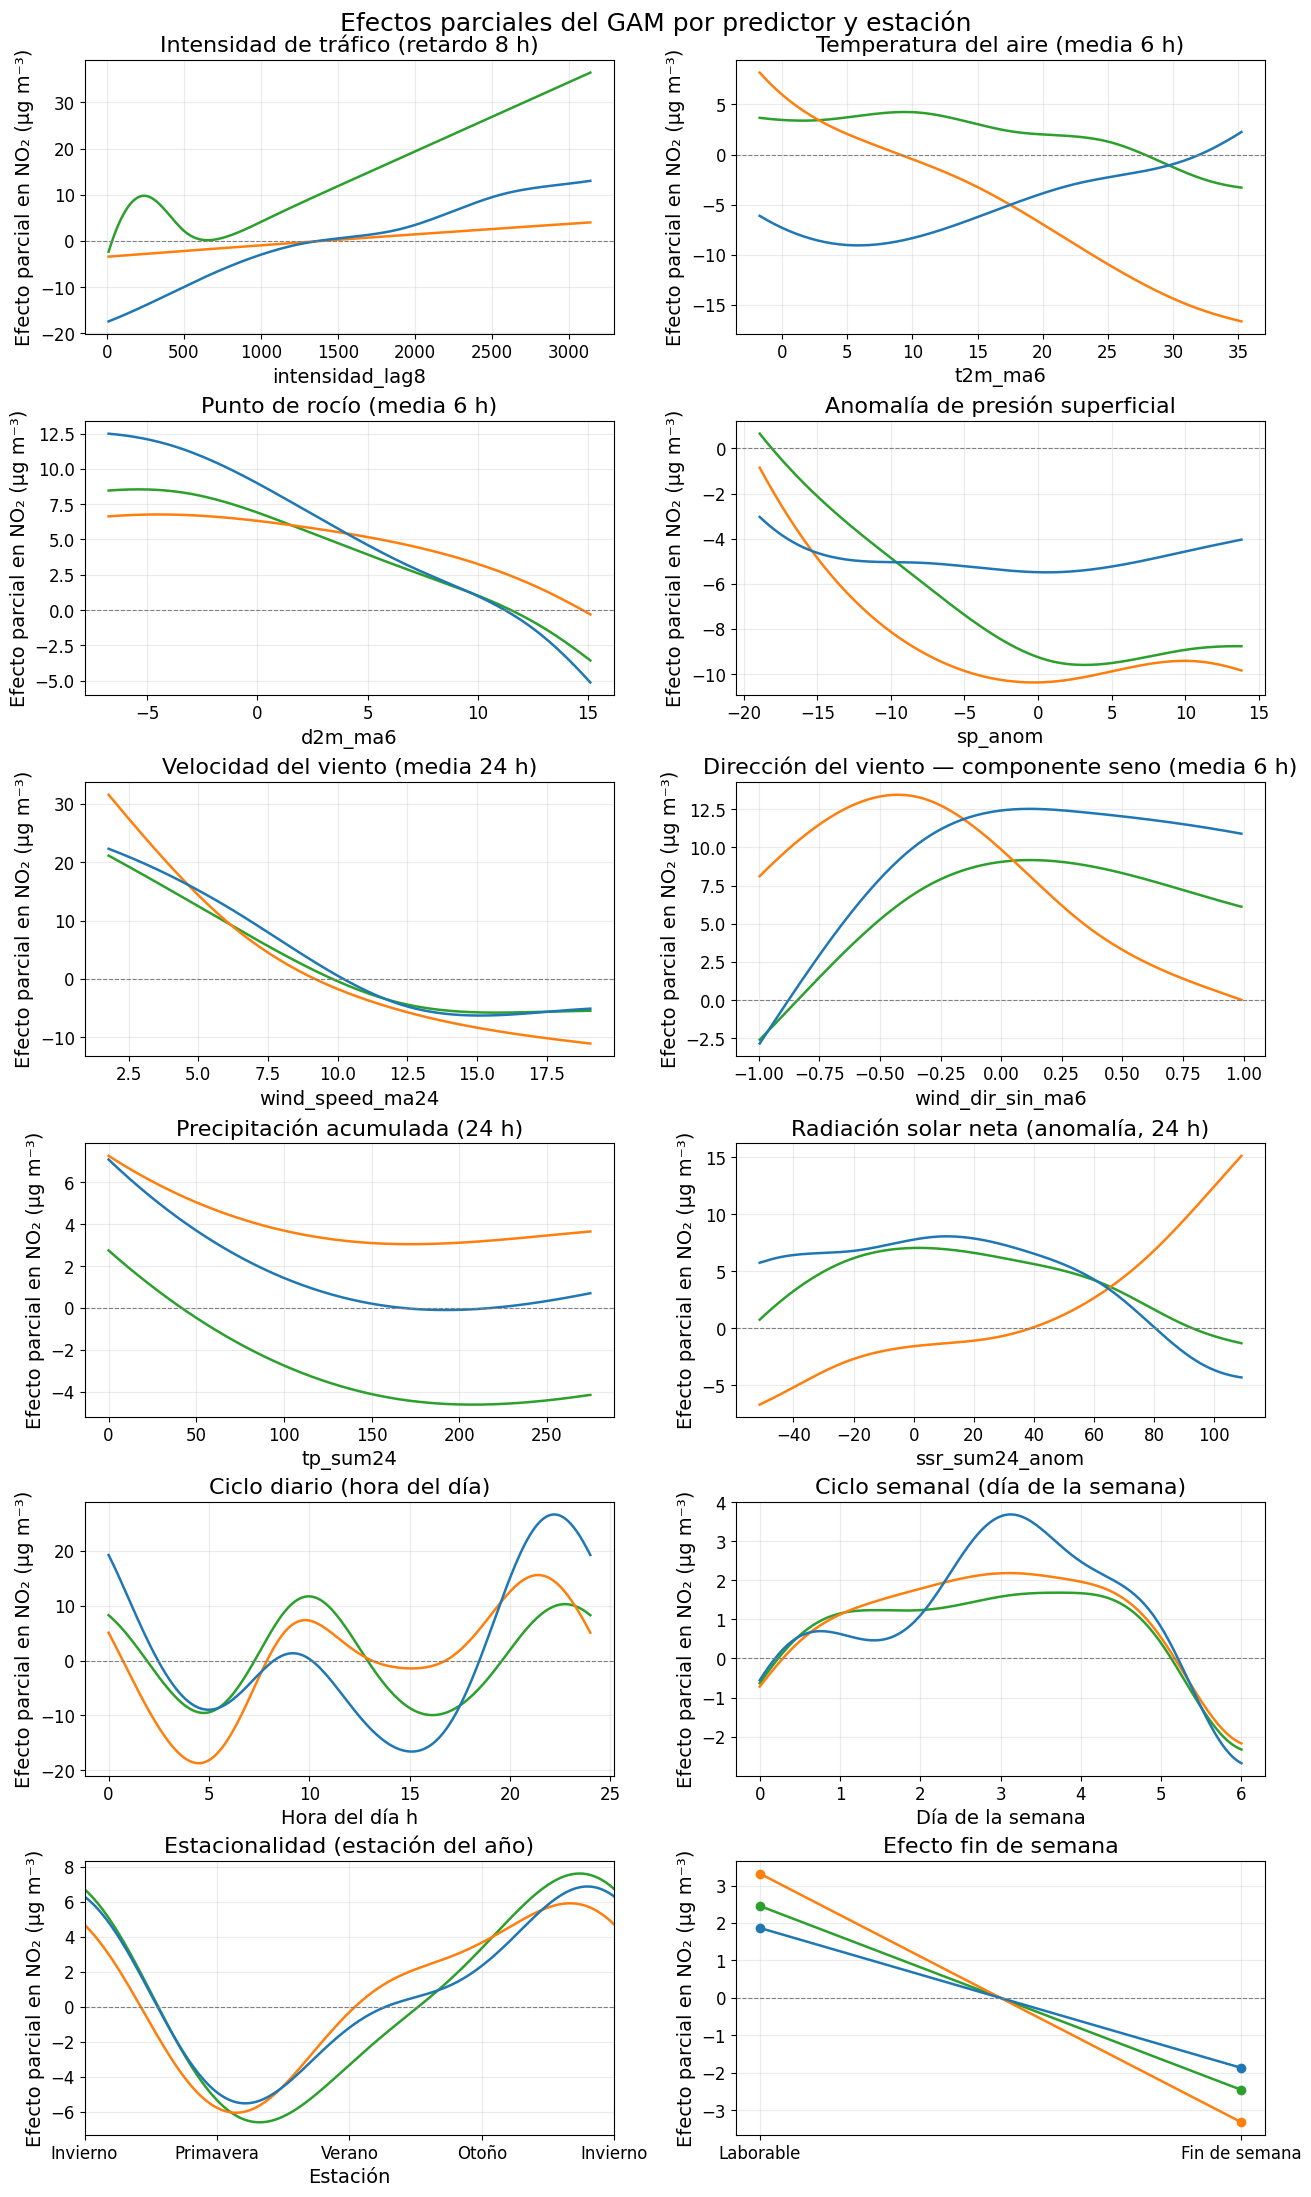

In [10]:

# =========================
# 5) Ejecutar
# =========================
# df = pd.read_parquet('tu_dataset.parquet')  # <- carga tu DF aquí
# Asegúrate de que df tiene 'no2_value' y columnas usadas en FEATURES + 'sp' y 'ssr_sum24'

models = {}
for sid in SENSORS:
    models[sid] = fit_by_sensor(df, sid)
    print(sid, 'RMSE test =', round(models[sid]['rmse'], 2))

plot_compare(models)